In [1]:
from pyDeepInsight import ImageTransformer#, LogScaler
import pandas as pd
import numpy as np
import pickle
import anndata
import random
from sklearn.manifold import TSNE
from sklearn import preprocessing
from timeit import default_timer as timer
import scanpy as sc

In [2]:
reference = anndata.read_h5ad("reference.h5ad")
reference.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,source,source.label,sample,chemistry,injury,injury.days,injury.agent,...,percent.miRNA,percent.snRNA,percent.antisense,stress.core,percent.lncRNA,scanorama_res.1.2_IDs,scanorama_factorIDs,tmp,cell,celltype_L2
cell,,,,,,,,,,,,,,,,,,,,,
Old_D3_5_C_AAGCGAGAGCCATTCA,scMuscle,26823.556301,4795,11,McKellar/Walter 2020,Old_D3_5_C,10x Genomics v3,D3.5,3.5,notexin,...,0.000000,0.003625,0.0,8.479327,0.542991,Monocyte (Patrolling),5,5,Old_D3_5_C_AAGCGAGAGCCATTCA,Monocytes
Old_D5_A_TAGGAGGAGGAGGTTC,scMuscle,42376.118709,5662,11,McKellar/Walter 2020,Old_D5_A,10x Genomics v3,D5,5.0,notexin,...,0.006834,0.000000,0.0,6.563047,0.801890,FAPs (Pro-remodeling),20,16,Old_D5_A_TAGGAGGAGGAGGTTC,FAPs
Old_D1_A_CATTTCATCTCAGGCG,scMuscle,2311.824526,1268,11,McKellar/Walter 2020,Old_D1_A,10x Genomics v3,D1,1.0,notexin,...,0.000000,0.000000,0.0,5.764414,1.329251,Monocyte (Inflammatory),7,7,Old_D1_A_CATTTCATCTCAGGCG,Monocytes
Old_D3_5_C_GTGAGGATCCCGAGTG,scMuscle,3057.595296,1555,11,McKellar/Walter 2020,Old_D3_5_C,10x Genomics v3,D3.5,3.5,notexin,...,0.000000,0.000000,0.0,7.304969,1.739467,Endothelial (Capillary),13,11,Old_D3_5_C_GTGAGGATCCCGAGTG,Endothelial
Old_D3_5_D_TAGACTGTCCTTTAGT,scMuscle,4322.018089,1694,11,McKellar/Walter 2020,Old_D3_5_D,10x Genomics v3,D3.5,3.5,notexin,...,0.000000,0.000000,0.0,4.189875,0.479956,Committed Progenitors,28,20,Old_D3_5_D_TAGACTGTCCTTTAGT,MuSCs


In [3]:
reference.X = reference.raw.X

In [4]:
#Normalize without batch effect correction
sc.pp.filter_genes(reference, min_counts=1) 
sc.pp.highly_variable_genes(reference, n_top_genes=3000, flavor="seurat_v3")
reference = reference[:,reference.var["highly_variable"] == True]
sc.pp.normalize_per_cell(reference)
sc.pp.log1p(reference)

/Users/cansahin/.pyenv/versions/scdeep_py310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/var/folders/rk/3wdx9sld7njgrrnst5g_drwc0000gn/T/ipykernel_81807/1293918860.py:5: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(reference)
/Users/cansahin/.pyenv/versions/scdeep_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:586: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell
/Users/cansahin/.pyenv/versions/scdeep_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:589: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


In [5]:
min_max_scaler = preprocessing.MinMaxScaler()
scaled = pd.DataFrame(np.asarray(reference.X.toarray()))
scaled = min_max_scaler.fit_transform(scaled)
scaled = pd.DataFrame(scaled)
scaled.index = reference.obs.index.values
scaled.columns = reference.var.index.values
scaled

,1,10,21,27,29,39,50,56,57,59,...,26271,26286,26317,26417,26545,26660,26857,26867,26889,27167
Old_D3_5_C_AAGCGAGAGCCATTCA,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Old_D5_A_TAGGAGGAGGAGGTTC,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Old_D1_A_CATTTCATCTCAGGCG,0.000000,0.0,0.0,0.564048,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Old_D3_5_C_GTGAGGATCCCGAGTG,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Old_D3_5_D_TAGACTGTCCTTTAGT,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Old_D7_B_CGCAGGTCACACACGC,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Old_D2_A_GTCCACTAGCGAGAAA,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Old_D5_B_TGGGCGTCATGACAGG,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Old_D3_5_C_CAATACGGTTCAGTAC,0.479413,0.0,0.0,0.561226,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
reference.var.to_csv("pretrained_genes.csv")

In [7]:
#Get cell-type information from initial reference dataset
ref = anndata.read_h5ad("reference.h5ad")
obs = ref.obs.loc[scaled.index.tolist()]
scaled["celltype_l2"] = obs["celltype_L2"]

tags = scaled['celltype_l2'].unique().tolist()
train_ls = []
val_ls = []

# Split dataset into training and validation by 90:10
for tag in tags:
    df = pd.DataFrame(scaled[scaled['celltype_l2'] == tag].index.values)
    train_part = df.sample(frac=0.90)[0].tolist()
    val_part = df[~df[0].isin(train_part)][0].tolist()
    
    train_ls += train_part
    val_ls += val_part

train_rna = scaled.loc[train_ls]
val_rna = scaled.loc[val_ls]
train_rna

,1,10,21,27,29,39,50,56,57,59,...,26286,26317,26417,26545,26660,26857,26867,26889,27167,celltype_l2
Old_D1_C_AGTAGCTTCGATGCAT,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monocytes
Old_D5_A_AATGCCATCAAGCCCG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monocytes
Old_D1_D_GAGGGATGTGGTTTAC,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monocytes
Old_D1_D_TCATCCGCATACAGAA,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monocytes
Old_D2_A_TTTCGATTCTTGGAAC,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Old_D2_C_CACTGGGGTGTCCATA,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neural
Old_D0_B_TGCGATATCGCTCCTA,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neural
Old_D0_C_CCAAGCGAGAGTCACG,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neural
Old_D0_C_TACATTCTCCGAAGGA,0.0,0.0,0.0,0.320440,0.0,0.525238,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neural


In [8]:
#Store cell-type information in this step for further training
pd.DataFrame(train_rna["celltype_l2"]).to_csv("trainy_pre.csv")
pd.DataFrame(val_rna["celltype_l2"]).to_csv("valy_pre.csv")
#pd.DataFrame(test_rna["celltype_l2"]).to_csv("testy_pre.csv")

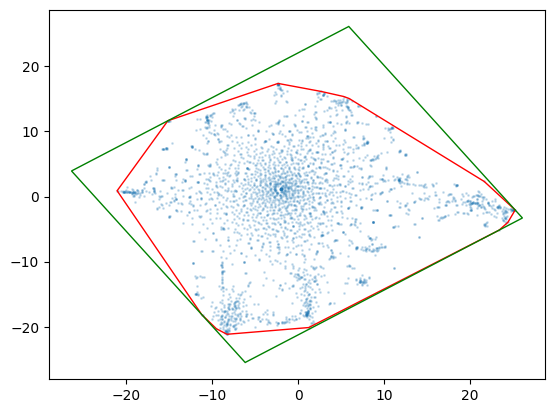

In [9]:
start = timer()
tsne = TSNE(n_components=2, perplexity=50, metric='euclidean', random_state=0, n_jobs=-1, learning_rate="auto", init='pca')
it = ImageTransformer(feature_extractor=tsne, pixels=224)#, random_state=0, n_jobs=-1)
it.fit(train_rna.iloc[:, :-1], plot=True)
#save image transformer
with open("img_transformer_pre.obj","wb") as f:
    pickle.dump(it, f)

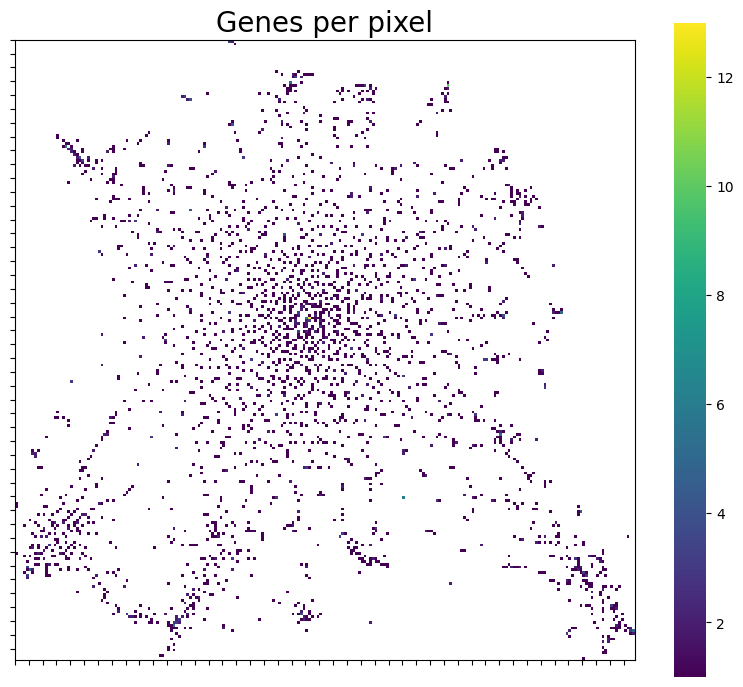

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 8.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel", fontsize = 20)

In [11]:
print(train_rna.columns)

Index(['1', '10', '21', '27', '29', '39', '50', '56', '57', '59',
       ...
       '26286', '26317', '26417', '26545', '26660', '26857', '26867', '26889',
       '27167', 'celltype_l2'],
      dtype='object', length=3001)


In [12]:
#Transform non-image processed datasets into images
label_col = "celltype_l2"
rna_list = np.array_split(train_rna, 4)
#Split the dataset to avoid memory problems
rna1 = rna_list[0]
rna2 = rna_list[1]
rna3 = rna_list[2]
rna4 = rna_list[3]

img_1 = (it.transform(rna1.drop(columns=[label_col]).values) * 255).astype(np.uint8)
img_2 = (it.transform(rna2.drop(columns=[label_col]).values) * 255).astype(np.uint8)
img_3 = (it.transform(rna3.drop(columns=[label_col]).values) * 255).astype(np.uint8)
img_4 = (it.transform(rna4.drop(columns=[label_col]).values) * 255).astype(np.uint8)

train_img = np.concatenate((img_1, img_2, img_3, img_4), axis=0)

val_img = (it.transform(val_rna.drop(columns=[label_col]).values) * 255).astype(np.uint8)
#test_img = (it.transform(test_rna.drop(columns=[label_col]).values) * 255).astype(np.uint8)


end = timer()
print("Image conversion time (s):", end - start)

/Users/cansahin/.pyenv/versions/scdeep_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Image conversion time (s): 47.878078958019614


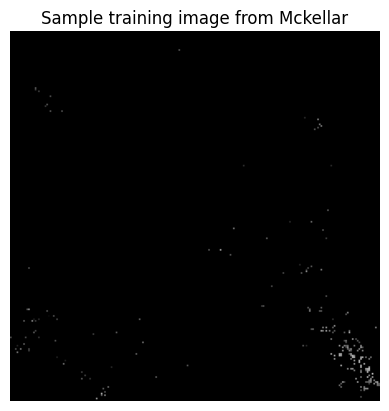

In [22]:
import matplotlib.pyplot as plt

# Pick an image index to visualize (e.g., 0 for the first one)
index =14

# Show the image (grayscale)
plt.imshow(train_img[index], cmap='gray')
plt.title(f"Sample training image from Mckellar")
plt.axis('off')
plt.show()

In [14]:
#Store processed images in npy format
path1 = 'train_pre.npy'
path2 = 'val_pre.npy'
#path3 = '/Users/cansahin/Desktop/2025 Winter/CSI 4900/option2/query_pre.npy'

np.save(path1, train_img)
np.save(path2, val_img)
#np.save(path3, test_img)

In [15]:

# Load test.h5ad
test_data = anndata.read_h5ad("test.h5ad")
# Align genes (columns) before applying scaler
test_data = test_data[:, reference.var.index]  # Reorder test genes to match reference
sc.pp.normalize_per_cell(test_data)
sc.pp.log1p(test_data)
scaled_test = pd.DataFrame(test_data.X.toarray())
scaled_test = pd.DataFrame(min_max_scaler.transform(scaled_test))  # use same scaler!
scaled_test.index = test_data.obs.index.values
scaled_test.columns = test_data.var.index.values


# # Load test.h5ad
# test_data = anndata.read_h5ad("test.h5ad")

# # Normalize expression values
# min_max_scaler = preprocessing.MinMaxScaler()
# scaled_test = pd.DataFrame(np.asarray(test_data.X.toarray()))
# scaled_test = min_max_scaler.fit_transform(scaled_test)
# scaled_test = pd.DataFrame(scaled_test)
# scaled_test.index = test_data.obs.index.values
# scaled_test.columns = test_data.var.index.values


/var/folders/rk/3wdx9sld7njgrrnst5g_drwc0000gn/T/ipykernel_81807/2307242554.py:5: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(test_data)
/Users/cansahin/.pyenv/versions/scdeep_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:586: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell
/Users/cansahin/.pyenv/versions/scdeep_py310/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:589: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(


In [16]:
# Load test.h5ad (reference-style)
ref = anndata.read_h5ad("test.h5ad")

# Make sure the indices align with the scaled expression matrix
obs = ref.obs.loc[scaled_test.index.tolist()]

# Attach cell type labels to scaled expression data
scaled_test["celltype_l2"] = obs["celltype_L2"]

# Store the full dataset as test set (no splitting)
test_rna = scaled_test.copy()

In [17]:
pd.DataFrame(test_rna["celltype_l2"]).to_csv("testy_pre.csv")

In [18]:
label_col = "celltype_l2"
rna_list_test = np.array_split(test_rna, 4)

rna_test1 = rna_list_test[0]
rna_test2 = rna_list_test[1]
rna_test3 = rna_list_test[2]
rna_test4 = rna_list_test[3]

img_test1 = (it.transform(rna_test1.drop(columns=[label_col]).values) * 255).astype(np.uint8)
img_test2 = (it.transform(rna_test2.drop(columns=[label_col]).values) * 255).astype(np.uint8)
img_test3 = (it.transform(rna_test3.drop(columns=[label_col]).values) * 255).astype(np.uint8)
img_test4 = (it.transform(rna_test4.drop(columns=[label_col]).values) * 255).astype(np.uint8)

test_img = np.concatenate((img_test1, img_test2, img_test3, img_test4), axis=0)

path3 = 'test_pre.npy'
np.save(path3, test_img)

/Users/cansahin/.pyenv/versions/scdeep_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
